# Financial Sentiment Analysis

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [ ]:
df = pd.read_csv('all-data.csv', encoding='ISO-8859-1', names = ['sentiment', 'text'])
df['sentiment_id'] = np.arange(0, len(df))

In [ ]:
df.head()

,sentiment,text,sentiment_id
0,neutral,"According to Gran , the company has no plans t...",0
1,neutral,Technopolis plans to develop in stages an area...,1
2,negative,The international electronic industry company ...,2
3,positive,With the new production plant the company woul...,3
4,positive,According to the company 's updated strategy f...,4


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sentiment     4846 non-null   object
 1   text          4846 non-null   object
 2   sentiment_id  4846 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 113.7+ KB


In [ ]:
sent_count = df.groupby('sentiment').count().reset_index().rename(columns={'text': 'cnt'})[['sentiment', 'cnt']]
sent_count

,sentiment,cnt
0,negative,604
1,neutral,2879
2,positive,1363


<BarContainer object of 3 artists>

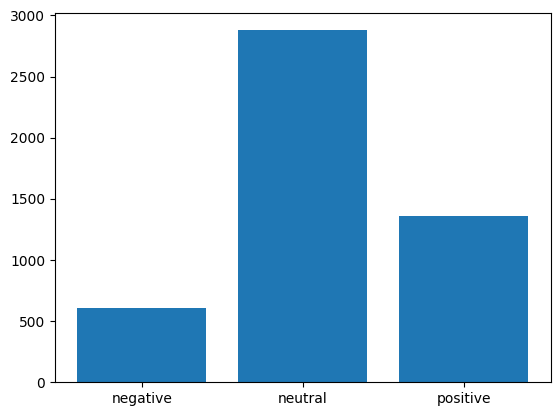

In [ ]:
plt.bar(sent_count['sentiment'], sent_count['cnt'])

In [ ]:
sia = SentimentIntensityAnalyzer()

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    text = row['text']
    id = row['sentiment_id']
    res[id] = (sia.polarity_scores(text))

  0%|          | 0/4846 [00:00<?, ?it/s]

In [ ]:
scores = pd.DataFrame(res).T
scores = scores.reset_index().rename(columns={'index':'sentiment_id'})
scores = scores.merge(df, how = 'left')
scores.head()

,sentiment_id,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos,sentiment,text
0,0,0.092,0.837,0.071,-0.1280,0.023855,0.695984,0.280161,neutral,"According to Gran , the company has no plans t..."
1,1,0.073,0.927,0.000,-0.2960,0.013208,0.839792,0.147000,neutral,Technopolis plans to develop in stages an area...
2,2,0.000,1.000,0.000,0.0000,0.511061,0.456079,0.032861,negative,The international electronic industry company ...
3,3,0.038,0.660,0.302,0.8555,0.002757,0.262543,0.734700,positive,With the new production plant the company woul...
4,4,0.000,0.853,0.147,0.6705,0.004494,0.691308,0.304198,positive,According to the company 's updated strategy f...


Text(0.5, 1.0, 'Compound Polarity Scores for Financial Data')

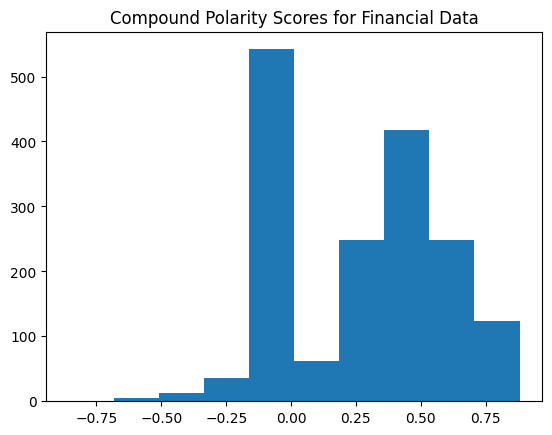

In [ ]:
plt.hist(scores['compound'], bins = 10)
plt.title("Compound Polarity Scores for Financial Data")

### Compare our Sentiment Analysis to the Roberta pre-trained model

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
example = "Oatmeal is bad"
sia.polarity_scores(example)

{'neg': 0.636, 'neu': 0.364, 'pos': 0.0, 'compound': -0.5423}

In [ ]:
encoded_text = tokenizer(example, return_tensors = 'pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
scores_dict

{'roberta_neg': 0.9590146,
 'roberta_neu': 0.035768818,
 'roberta_pos': 0.0052165436}

In [ ]:
def roberta_polarity_scores(text):
    encoded_text = tokenizer(text, return_tensors = 'pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
    return scores_dict

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    text = row['text']
    id = row['sentiment_id']
    vader_result = sia.polarity_scores(text)
    roberta_result = roberta_polarity_scores(text)
    combined = {**vader_result, **roberta_result}
    res[id] = combined

  0%|          | 0/4846 [00:00<?, ?it/s]

In [ ]:
res_df = pd.DataFrame(res).T
res_df = res_df.reset_index().rename(columns={'index':'sentiment_id'})
res_df = res_df.merge(df, how = 'left')
res_df

,sentiment_id,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos,sentiment,text
0,0,0.092,0.837,0.071,-0.1280,0.023855,0.695984,0.280161,neutral,"According to Gran , the company has no plans t..."
1,1,0.073,0.927,0.000,-0.2960,0.013208,0.839792,0.147000,neutral,Technopolis plans to develop in stages an area...
2,2,0.000,1.000,0.000,0.0000,0.511061,0.456079,0.032861,negative,The international electronic industry company ...
3,3,0.038,0.660,0.302,0.8555,0.002757,0.262543,0.734700,positive,With the new production plant the company woul...
4,4,0.000,0.853,0.147,0.6705,0.004494,0.691308,0.304198,positive,According to the company 's updated strategy f...
...,...,...,...,...,...,...,...,...,...,...
4841,4841,0.272,0.656,0.072,-0.7269,0.636021,0.343294,0.020685,negative,LONDON MarketWatch -- Share prices ended lower...
4842,4842,0.000,1.000,0.000,0.0000,0.277083,0.663619,0.059298,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,4843,0.000,0.751,0.249,0.7430,0.226839,0.692909,0.080253,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,4844,0.000,0.934,0.066,0.4404,0.094834,0.797649,0.107518,negative,Net sales of the Paper segment decreased to EU...


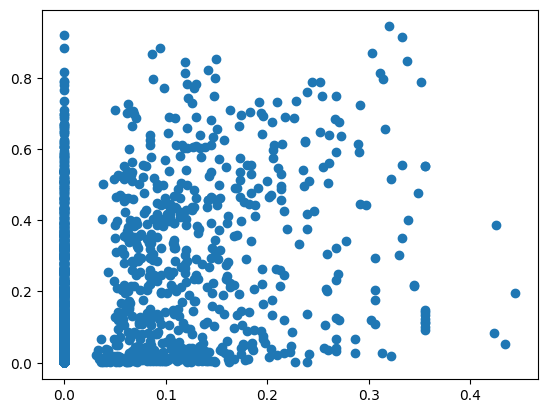

In [ ]:
plt.scatter(res_df['neg'], res_df['roberta_neg'])

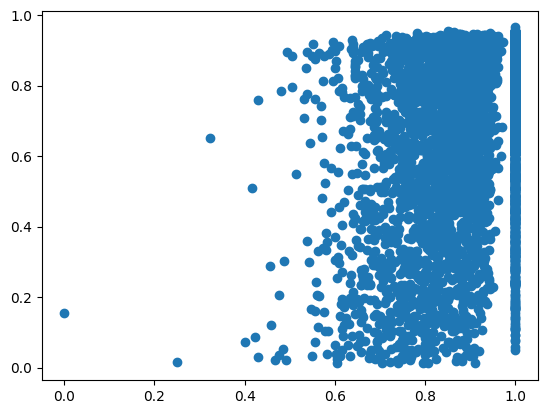

In [ ]:
plt.scatter(res_df['neu'], res_df['roberta_neu'])

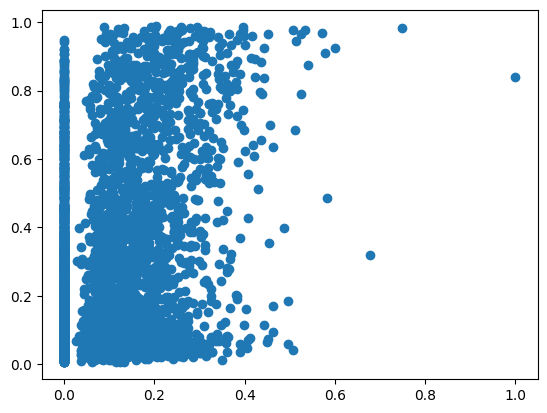

In [ ]:
plt.scatter(res_df['pos'], res_df['roberta_pos'])

## Modelling

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
df = pd.read_csv('all-data.csv', encoding='ISO-8859-1', names = ['sentiment', 'text'])
df = df[df['sentiment'] != 'neutral']
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == "positive" else 0)
df.head()

,sentiment,text
2,0,The international electronic industry company ...
3,1,With the new production plant the company woul...
4,1,According to the company 's updated strategy f...
5,1,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
6,1,"For the last quarter of 2010 , Componenta 's n..."


In [ ]:
pattern = r"[a-zA-Z]+"

In [ ]:
vector = TfidfVectorizer(
    token_pattern = pattern,
    stop_words = list(ENGLISH_STOP_WORDS),
    ngram_range = (1, 2),
    max_features = 600)

In [ ]:
vector.fit(df['text'])

TfidfVectorizer(max_features=600, ngram_range=(1, 2),
                stop_words=['too', 'could', 'two', 'thereafter', 'as',
                            'serious', 'seemed', 'such', 'became', 'wherever',
                            'therein', 'without', 'would', 'whither', 'namely',
                            'during', 'every', 'hence', 'some', 'becomes',
                            'neither', 'back', 'except', 'over', 'throughout',
                            'everyone', 'very', 'yourself', 'enough', 'into', ...],
                token_pattern='[a-zA-Z]+')

In [ ]:
tokenized_feats = vector.transform(df["text"])

In [ ]:
features = pd.DataFrame(data = tokenized_feats.toarray(), columns = vector.get_feature_names_out())

In [ ]:
features

,ab,able,ac,ac million,according,acquisition,added,addition,adp,adp news,...,x,x ac,year,year ago,year earlier,year eur,year year,years,yesterday,yit
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.225827,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.260849,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.101199,0.0,0.153545,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1962,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
1963,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
1964,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
1965,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


In [ ]:
df['char_count'] = df['text'].str.count(r"\S")
df['word_count'] = df['text'].str.count(pattern)
df['avg_word_length'] = df['char_count'] / df['word_count']


In [ ]:
X = pd.concat([features.reset_index(drop=True), df.loc[:, 'char_count':].reset_index(drop = True)], axis = 1)
y = df['sentiment']
X.isna().sum()

ab                 0
able               0
ac                 0
ac million         0
according          0
                  ..
yesterday          0
yit                0
char_count         0
word_count         0
avg_word_length    0
Length: 603, dtype: int64

In [ ]:
X.shape

(1967, 603)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 123)

In [ ]:
random_forest = RandomForestClassifier(random_state = 123).fit(X_train, y_train)

In [ ]:
y_pred = random_forest.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.53      0.62       114
           1       0.83      0.93      0.87       280

    accuracy                           0.81       394
   macro avg       0.78      0.73      0.74       394
weighted avg       0.80      0.81      0.80       394



In [ ]:
round(accuracy_score(y_test, y_pred), 2)

0.81

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

In [ ]:
mat = confusion_matrix(y_test, y_pred)

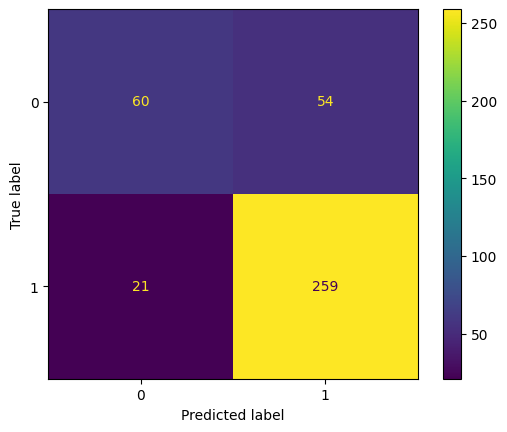

In [ ]:
disp = ConfusionMatrixDisplay(mat)
disp.plot()

Save our Model

In [ ]:
import pickle

In [ ]:
financial_sentiment_model = "financial_sentiment_classifier.pkl"

In [ ]:
with open(financial_sentiment_model, 'wb') as file:  
    pickle.dump(model, file)

NameError: name 'model' is not defined